In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import warnings
# Supprimer les warnings pour un affichage plus propre
warnings.filterwarnings('ignore')

# Configuration de style pour les graphiques
plt.style.use('default')
sns.set_palette("husl")


In [29]:
def load_bitcoin_data(file_path):
    """
    Charge les données Bitcoin depuis le fichier CSV
    """
    try:
        # Charger les données
        df = pd.read_csv(file_path)
        
        # Convertir la colonne de temps en datetime
        df['Open time'] = pd.to_datetime(df['Open time'])
        
        # Nettoyer les noms de colonnes (enlever les espaces)
        df.columns = df.columns.str.strip()
        
        # Définir l'index comme datetime
        df.set_index('Open time', inplace=True)
        
        print(f"Données chargées avec succès!")
        print(f"Période: {df.index.min()} à {df.index.max()}")
        print(f"Nombre d'enregistrements: {len(df):,}")
        
        return df
        
    except Exception as e:
        print(f"Erreur lors du chargement des données: {e}")
        return None

In [30]:
def basic_statistics(df):
    """
    Affiche les statistiques de base des données Bitcoin
    """
    print("\n" + "="*50)
    print("STATISTIQUES DESCRIPTIVES")
    print("="*50)
    
    # Statistiques pour les prix principaux
    price_cols = ['Open', 'High', 'Low', 'Close']
    print(df[price_cols].describe())
    
    print(f"\n📈 Prix le plus haut: ${df['High'].max():,.2f}")
    print(f"📉 Prix le plus bas: ${df['Low'].min():,.2f}")
    print(f"💰 Prix de clôture actuel: ${df['Close'].iloc[-1]:,.2f}")
    
    # Calcul de la volatilité quotidienne moyenne
    df['Daily_Range'] = ((df['High'] - df['Low']) / df['Open']) * 100
    print(f"🎯 Volatilité moyenne quotidienne: {df['Daily_Range'].mean():.2f}%")

In [31]:

print("🚀 ANALYSE DES DONNÉES BITCOIN")
print("="*50)

# Charger les données
file_path_15m = "btc_15m_data_2018_to_2025.csv"
file_path_1h = "btc_1h_data_2018_to_2025.csv"
file_path_4h = "btc_4h_data_2018_to_2025.csv"
file_path_1d = "btc_1d_data_2018_to_2025.csv"

df_15m = load_bitcoin_data(file_path_15m)
df_1h = load_bitcoin_data(file_path_1h)
df_4h = load_bitcoin_data(file_path_4h)
df_1d = load_bitcoin_data(file_path_1d)

# Afficher les statistiques de base pour les données 1 jour
print("\n🔍 STATISTIQUES DES DONNÉES QUOTIDIENNES")
basic_statistics(df_1d)

🚀 ANALYSE DES DONNÉES BITCOIN
Données chargées avec succès!
Période: 2018-01-01 00:00:00 à 2025-12-10 23:15:00
Nombre d'enregistrements: 277,963
Données chargées avec succès!
Période: 2018-01-01 00:00:00 à 2025-12-23 21:00:00
Nombre d'enregistrements: 69,815
Données chargées avec succès!
Période: 2018-01-01 00:00:00 à 2025-12-23 12:00:00
Nombre d'enregistrements: 17,469
Données chargées avec succès!
Période: 2018-01-01 00:00:00+00:00 à 2025-12-24 00:00:00+00:00
Nombre d'enregistrements: 2,915

🔍 STATISTIQUES DES DONNÉES QUOTIDIENNES

STATISTIQUES DESCRIPTIVES
                Open           High            Low          Close
count    2915.000000    2915.000000    2915.000000    2915.000000
mean    37110.275804   37832.322576   36337.370182   37142.135122
std     32150.297721   32542.441914   31743.382562   32173.536017
min      3211.710000    3276.500000    3156.260000    3211.720000
25%      9433.115000    9667.000000    9206.220000    9437.825000
50%     27242.590000   27756.840000   

## Debut de l'implémentation LSTM - Dataset 15min

On va tenter de prédire la pente du marché, une direction future :
y = -1 → baisse
y =  0 → neutre
y = +1 → hausse

Quel horizon de prédiction ? 
On va tenter de débuter par H = 16, soit prédire la direction pour les 4 heures qui suivent

On implémentera cette formule : r(t,h) = prix(t+h)-prix(t) / prix(t)
Cette formule nous donnera donc une premier pourcentage de baisse/hausse. Ajouté à un seuil défini pour plus de robustesse, on pourra avoir la premiere idée de notre pente, et donc ajouter notre label pour les données d'entrainement
si r > +ε → +1
si r < -ε → -1
sinon → 0

In [32]:
def create_target(df, price_col='Close', horizon=16, threshold=0.002):
    """
    Génération vectorisée de la cible (Target).
    1 = Hausse, -1 = Baisse, 0 = Neutre
    
    Args:
        df: DataFrame contenant les prix
        horizon: Nombre de périodes vers le futur (ex: 16 pour 4h en bougies 15m)
        threshold: Le pourcentage minimum pour valider un mouvement (ex: 0.002 pour 0.2%)
    """
    # Calcul du pourcentage de variation futur
    future_prices = df[price_col].shift(-horizon)
    current_prices = df[price_col]
    
    future_pct = (future_prices - current_prices) / current_prices
    
    conditions = [
        (future_pct > threshold),  # Hausse significative
        (future_pct < -threshold)  # Baisse significative
    ]
    
    choices = [1, -1]
    
    # np.select assigne 1 ou -1 selon les conditions, sinon 0 par défaut
    targets = np.select(conditions, choices, default=0)
    return targets, future_pct

In [33]:
print(df_15m.head())

                         Open      High       Low     Close      Volume  \
Open time                                                                 
2018-01-01 00:00:00  13715.65  13715.65  13400.01  13556.15  123.616013   
2018-01-01 00:15:00  13533.75  13550.87  13402.00  13521.12   98.136430   
2018-01-01 00:30:00  13500.00  13545.37  13450.00  13470.41   79.904037   
2018-01-01 00:45:00  13494.65  13690.87  13450.00  13529.01  141.699719   
2018-01-01 01:00:00  13528.99  13571.74  13402.28  13445.63   72.537533   

                                      Close time  Quote asset volume  \
Open time                                                              
2018-01-01 00:00:00  2018-01-01 00:14:59.999000         1.675545e+06   
2018-01-01 00:15:00  2018-01-01 00:29:59.999000         1.321757e+06   
2018-01-01 00:30:00  2018-01-01 00:44:59.999000         1.078825e+06   
2018-01-01 00:45:00  2018-01-01 00:59:59.999000         1.917783e+06   
2018-01-01 01:00:00  2018-01-01 01:14:59.9

In [34]:
# On travaille sur une copie pour ne pas toucher aux données brutes
df_features = df_15m.copy()

# --- 1. INDICATEURS TECHNIQUES (FEATURE ENGINEERING) ---
df_features['Range_Pct'] = (df_features['High'] - df_features['Low']) / df_features['Open']

df_features['Log_Ret'] = np.log(df_features['Close'] / df_features['Close'].shift(1))

# Moyenne Mobile Simple (SMA) pour la tendance (50 périodes)
df_features['SMA_50'] = df_features['Close'].rolling(window=50).mean()

# Distance au SMA (Normalisée) : Indique si le prix est sur-étendu
df_features['Dist_SMA_50'] = (df_features['Close'] - df_features['SMA_50']) / df_features['SMA_50']

# RSI (Relative Strength Index) - Calcul manuel vectorisé
def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df_features['RSI'] = calculate_rsi(df_features['Close'])

# Volume Relatif (Volume actuel / Moyenne des 32 derniers volumes)
df_features['Vol_Ratio'] = df_features['Volume'] / df_features['Volume'].rolling(window=32).mean()


# --- 2. CRÉATION DE LA CIBLE (LABELING) ---

HORIZON_PREDICTION = 16  # 4 heures
SEUIL_VOLATILITE = 0.003

targets, future_ret = create_target(df_features, horizon=HORIZON_PREDICTION, threshold=SEUIL_VOLATILITE)

df_features['Target'] = targets
df_features['Future_Ret'] = future_ret # On enlevera ça après le train

# --- 3. NETTOYAGE ---

df_features.dropna(inplace=True)

# Sélection des colonnes finales pour l'entraînement
features_cols = ['Range_Pct', 'Log_Ret', 'Dist_SMA_50', 'RSI', 'Vol_Ratio']
target_col = ['Target']

print(f"Dataset prêt. Taille : {len(df_features)} lignes")
print(df_features[features_cols + target_col].head())

Dataset prêt. Taille : 277898 lignes
                     Range_Pct   Log_Ret  Dist_SMA_50        RSI  Vol_Ratio  \
Open time                                                                     
2018-01-01 12:15:00   0.014429 -0.007673    -0.025498  33.584776   0.829066   
2018-01-01 12:30:00   0.007551  0.004089    -0.020988  31.291035   0.823557   
2018-01-01 12:45:00   0.008127 -0.002092    -0.022529  31.670116   0.692334   
2018-01-01 13:00:00   0.029255 -0.010025    -0.031662  24.832958   2.470803   
2018-01-01 13:15:00   0.009529 -0.004910    -0.035614  22.358451   1.137726   

                     Target  
Open time                    
2018-01-01 12:15:00      -1  
2018-01-01 12:30:00      -1  
2018-01-01 12:45:00      -1  
2018-01-01 13:00:00       1  
2018-01-01 13:15:00       1  


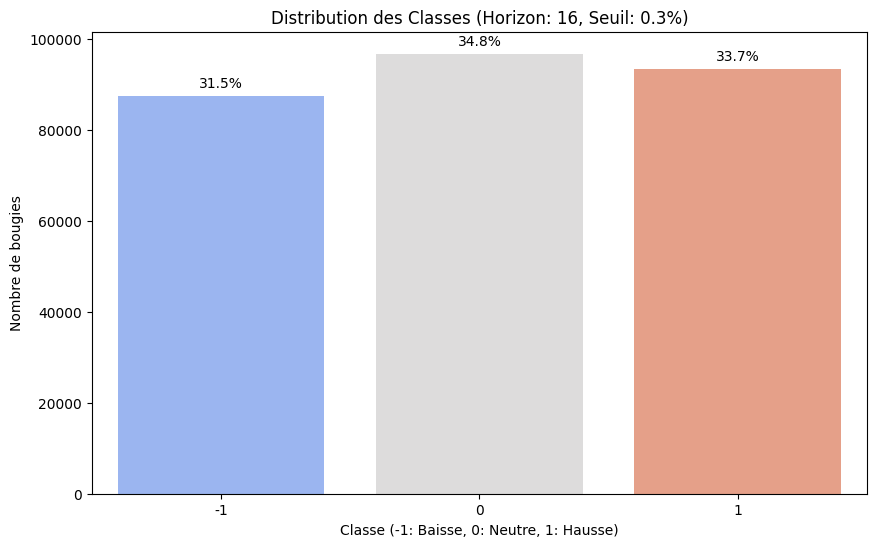

In [35]:
plt.figure(figsize=(10, 6))

# Calcul des pourcentages
distribution = df_features['Target'].value_counts(normalize=True) * 100

ax = sns.countplot(x='Target', data=df_features, palette='coolwarm')
plt.title(f'Distribution des Classes (Horizon: 16, Seuil: {SEUIL_VOLATILITE*100}%)')
plt.xlabel('Classe (-1: Baisse, 0: Neutre, 1: Hausse)')
plt.ylabel('Nombre de bougies')
for p in ax.patches:
    ax.annotate(f'{p.get_height()/len(df_features)*100:.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

plt.show()

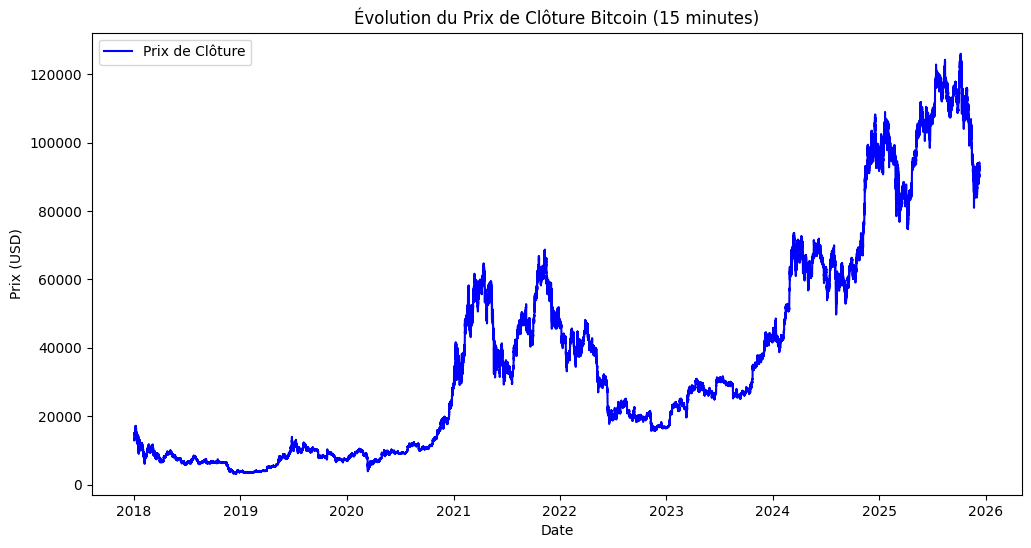

In [36]:
#Visualiser les prix

plt.figure(figsize=(12, 6))
plt.plot(df_features.index, df_features['Close'], label='Prix de Clôture', color='blue')
plt.title('Évolution du Prix de Clôture Bitcoin (15 minutes)')
plt.xlabel('Date')
plt.ylabel('Prix (USD)')
plt.legend()
plt.show()

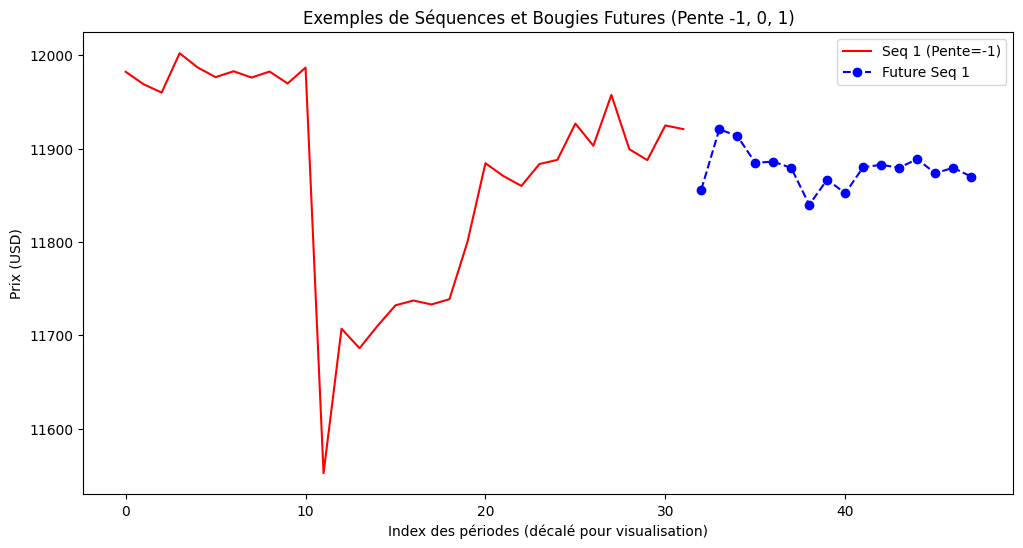

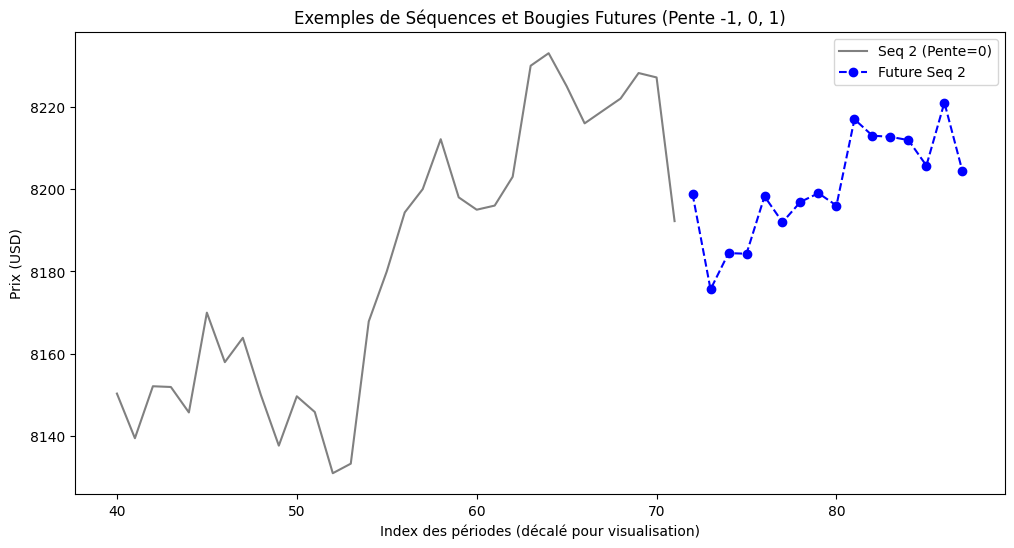

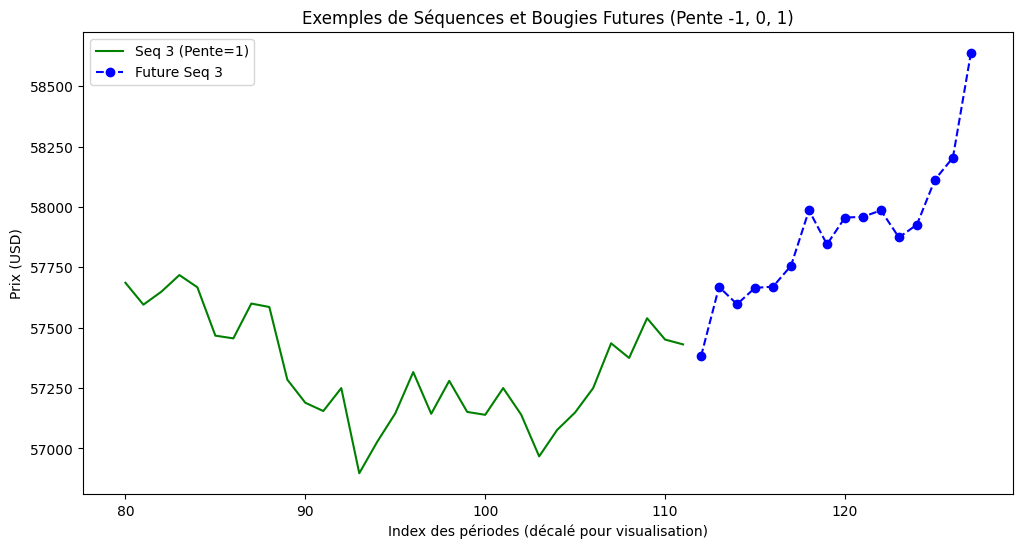

In [37]:
# Fonction pour récupérer un indice aléatoire pour une pente spécifique
def random_index_for_pente(df, pente_val):
    indices = np.where(df['Target'].values == pente_val)[0]
    # Filtrer les indices qui permettent de prendre 32 bougies + 16 futures
    valid_indices = [idx for idx in indices if idx >= 31 and idx + 16 < len(df)]
    if len(valid_indices) == 0:
        return None
    # Choisir un indice aléatoire parmi les valides
    return np.random.choice(valid_indices)

# Récupérer les indices pour chaque pente
idx_neg = random_index_for_pente(df_features, -1)
idx_zero = random_index_for_pente(df_features, 0)
idx_pos = random_index_for_pente(df_features, 1)

example_indices = [idx_neg, idx_zero, idx_pos]



for i, label_idx in enumerate(example_indices):
    # Séquence LSTM : 32 bougies avant le label
    plt.figure(figsize=(12, 6))
    seq = df_features['Close'].values[label_idx-31:label_idx+1]
    pente = df_features['Target'].values[label_idx]
    color_seq = 'green' if pente == 1 else 'red' if pente == -1 else 'gray'

    # Prochaines 16 bougies (horizon)
    future = df_features['Close'].values[label_idx+1:label_idx+17]

    # Décalage horizontal pour visualisation
    offset = i * 40
    plt.plot(range(offset, offset+32), seq, color=color_seq, label=f'Seq {i+1} (Pente={pente})')
    plt.plot(range(offset+32, offset+48), future, color='blue', linestyle='--', marker='o', label=f'Future Seq {i+1}')

    plt.title('Exemples de Séquences et Bougies Futures (Pente -1, 0, 1)')
    plt.xlabel('Index des périodes (décalé pour visualisation)')
    plt.ylabel('Prix (USD)')
    plt.legend()
    plt.show()


## Implémentation du LSTM avec Pytorch

In [38]:
from torch.utils.data import Dataset, DataLoader

import torch
import torch.nn as nn

# Verify PyTorch is properly imported
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Torch loaded from: {getattr(torch, '__file__', 'unknown')}" )

# Extra diagnostics
print("\n=== PyTorch CUDA Diagnostics ===")
print(f"torch.version.cuda: {getattr(torch.version, 'cuda', None)}")
print(f"torch.cuda.device_count(): {torch.cuda.device_count()}")
print(f"cudnn version: {torch.backends.cudnn.version() if torch.backends.cudnn.is_available() else None}")
try:
    from io import StringIO
    import sys
    buf = StringIO()
    # torch.__config__.show() prints to stdout
    torch.__config__.show()
except Exception as e:
    print(f"torch.__config__.show() error: {e}")

class BTCSeqDataset(Dataset):
    def __init__(self, df, seq_len = 32, horizon = 16, feature_cols=None):
        self.seq_len = seq_len
        self.horizon = horizon
        self.feature_cols = feature_cols or ['Range_Pct', 'Log_Ret', 'Dist_SMA_50', 'RSI', 'Vol_Ratio']
        
        #Normalisation simple
        self.data = df[self.feature_cols].values
        self.data_mean = self.data.mean(axis=0)
        self.data_std = self.data.std(axis=0)
        self.data_norm = (self.data - self.data_mean) / (self.data_std + 1e-8)
        
        #Labels
        self.labels = df['Target'].values
        
        self.sequences = []
        self.seq_labels = []
        
        for i in range(len(df)-seq_len-horizon+1):
            self.sequences.append(self.data_norm[i:i+seq_len])
            self.seq_labels.append(self.labels[i+seq_len-1])
            
        self.sequences = np.array(self.sequences, dtype=np.float32)
        self.seq_labels = np.array(self.seq_labels, dtype=np.int64)
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.seq_labels[idx]

PyTorch version: 2.6.0+cu124
CUDA available: True
Torch loaded from: c:\Users\samye\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\__init__.py

=== PyTorch CUDA Diagnostics ===
torch.version.cuda: 12.4
torch.cuda.device_count(): 1
cudnn version: 90100


In [39]:
seq_len = 32
horizon = 16
feature_cols = ['Range_Pct', 'Log_Ret', 'Dist_SMA_50', 'RSI', 'Vol_Ratio']

dataset = BTCSeqDataset(df_features, seq_len=seq_len, horizon=horizon, feature_cols=feature_cols)

# Split chronologique
num_samples = len(dataset)
train_idx = int(num_samples * 0.7)
val_idx = int(num_samples * 0.85)

train_dataset = torch.utils.data.Subset(dataset, range(0, train_idx))
val_dataset = torch.utils.data.Subset(dataset, range(train_idx, val_idx))
test_dataset = torch.utils.data.Subset(dataset, range(val_idx, num_samples))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [40]:
class LSTMPredictor(nn.Module):
    def __init__(self, input_size, hidden_size = 128, num_layers = 2, num_classes = 3, dropout = 0.3):
        super(LSTMPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[: , -1 , :]
        out = self.fc(out)
        return out

In [41]:
from copy import deepcopy
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model = LSTMPredictor(input_size=len(feature_cols)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 50
patience = 5
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

# Track metrics for visualization
train_losses = []
val_losses = []
val_accuracies = []

print("Début de l'entraînement du modèle LSTM...")
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_batch = y_batch + 1  # Labels passent de {-1,0,1} à {0,1,2}
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * X_batch.size(0)

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Validation
    model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_batch = y_batch + 1  # Labels passent de {-1,0,1} à {0,1,2}
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            running_val_loss += loss.item() * X_batch.size(0)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    val_acc = correct / total if total > 0 else 0.0
    val_accuracies.append(val_acc)

    # Early stopping 
    if epoch_val_loss < best_val_loss - 1e-4:
        best_val_loss = epoch_val_loss
        patience_counter = 0
        best_model_state = deepcopy(model.state_dict())
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping déclenché à l'époque {epoch+1}")
            break

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f} - Val Loss: {epoch_val_loss:.4f} - Val Acc: {val_acc:.4f}")

# Restaurer le meilleur modèle (val_loss)
if best_model_state is not None:
    model.load_state_dict(best_model_state)


Using device: cuda
Début de l'entraînement du modèle LSTM...
Epoch 1/50 - Train Loss: 1.0505 - Val Loss: 1.0703 - Val Acc: 0.4473
Epoch 2/50 - Train Loss: 1.0469 - Val Loss: 1.0574 - Val Acc: 0.4490
Epoch 3/50 - Train Loss: 1.0452 - Val Loss: 1.0490 - Val Acc: 0.4481
Epoch 4/50 - Train Loss: 1.0438 - Val Loss: 1.0458 - Val Acc: 0.4498
Epoch 5/50 - Train Loss: 1.0425 - Val Loss: 1.0426 - Val Acc: 0.4523
Epoch 6/50 - Train Loss: 1.0408 - Val Loss: 1.0422 - Val Acc: 0.4526
Epoch 7/50 - Train Loss: 1.0389 - Val Loss: 1.0400 - Val Acc: 0.4541
Epoch 8/50 - Train Loss: 1.0370 - Val Loss: 1.0396 - Val Acc: 0.4546
Epoch 9/50 - Train Loss: 1.0343 - Val Loss: 1.0374 - Val Acc: 0.4548
Epoch 10/50 - Train Loss: 1.0310 - Val Loss: 1.0394 - Val Acc: 0.4537
Epoch 11/50 - Train Loss: 1.0278 - Val Loss: 1.0426 - Val Acc: 0.4526
Epoch 12/50 - Train Loss: 1.0246 - Val Loss: 1.0482 - Val Acc: 0.4537
Epoch 13/50 - Train Loss: 1.0201 - Val Loss: 1.0478 - Val Acc: 0.4535
Early stopping déclenché à l'époque 14

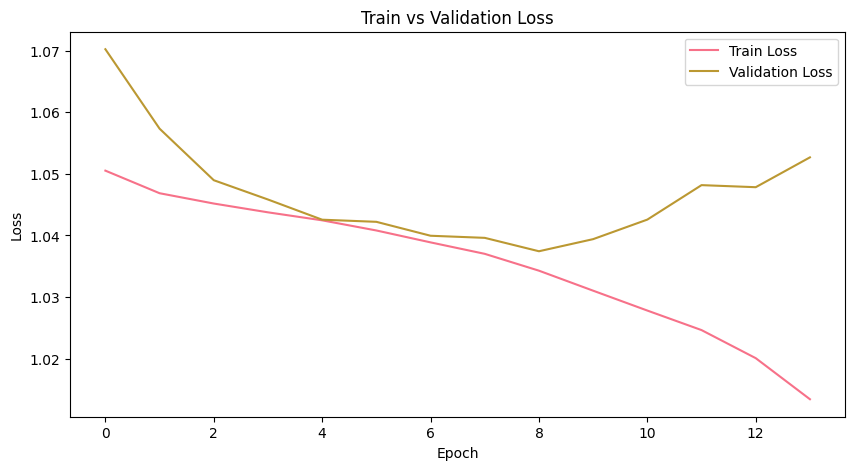

In [43]:
#Visualisation des pertes d'entraînement et de validation
plt.figure(figsize=(10, 5)) 
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()




